In [279]:
import os
import progressbar as pb
from progressbar import ProgressBar, Percentage, Bar, ETA, FileTransferSpeed
import time
import multiprocessing

import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import missingno as msno
import pprint
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D


import scipy as sp
from scipy import stats
from mca import *
from scipy.stats import boxcox
import hdbscan


%matplotlib inline
pd.set_option("display.max_columns",80)
pd.set_option('display.max_rows', 1200)
warnings.filterwarnings("ignore")

from IPython.display import HTML

import plotly
import cufflinks as cf
import plotly.plotly as py
import plotly.graph_objs as go
cf.go_offline()
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly.graph_objs import *
# tls.set_credentials_file(username='darshan.bhansali', api_key='38zZ2TS4ob4feqV0bvR0')
# tls.set_credentials_file(username='darshan-b', api_key='KuC894mmVN7kBiZZyffO')
# tls.set_credentials_file(username='darshan18', api_key='dhwPNrhtYUy2iMbQqALn')

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss,classification_report
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering,FeatureAgglomeration,KMeans,FeatureAgglomeration, DBSCAN,SpectralClustering,Birch,MeanShift

In [2]:
# traffic_column_names =['Recorded_Time','Received_Time','Serial_Number','Type','Subtype','Config_Version','Generated_Time',
#                'Source_IP','Destination_IP','NAT_Source_IP','NAT_Destination_IP','Rule_Name','Source_User','Destination_User',
#                'Application','Virtual_System','Source_Zone','Destination_Zone','Ingress_Interface','Egress_Interface',
#                'Log_Forwarding_Profile','Future_Use','Session_ID','Repeat_Count','Source_Port','Destination_Port',
#                'NAT_Source_Port','NAT_Destination_Port','Flags','Protocol','Action','Bytes','Bytes_sent','Bytes_received',
#                'Packets','Start_Time','Elapsed_Time','Category','Future_Use_1','Sequence_Number','Action_flags','Source_Location',
#                'Destination_Location', 'Future_Use_2', 'Packets Sent', 'Packets Received', 'Session End Reason','Drop_1','Drop_2',
#                'Drop_3','Drop_4','Drop_5','device_name','From_Policy','Drop_6','Drop_7','Drop_8','Drop_9','Drop_10','Drop_11',
#                'Drop_12']

In [31]:
def read_logs(rel_path,compression=None,extension=None,column_names=None):
    path = rel_path
    zip_files = [f for f in os.listdir(path) if f.endswith(extension)]
    paths = [path + x for x in zip_files]
    df=pd.DataFrame()
    for i in range(0,len(paths)):
        try:
            demo_df=pd.read_csv(paths[i],header=None,infer_datetime_format=True,low_memory=True,
                                compression=compression,error_bad_lines=False,warn_bad_lines=False,memory_map=True)
        except:
#             print(i,paths[i],"\n")
            continue
        if demo_df.empty!=True:
            df=df.append(demo_df)
        else:
            print("Not empty")
    df.columns=column_names
    return df

In [32]:
root_paths=['../../data/2017-09-26/','../../data/2017-09-27/','../../data/2017-09-28/','../../data/2017-09-29/',
            '../../data/2017-09-30/','../../data/2017-10-01/','../../data/2017-10-02/','../../data/2017-10-03/',
            '../../data/2017-10-04/','../../data/2017-10-05/','../../data/2017-10-06/','../../data/2017-10-07/',
            '../../data/2017-10-08/','../../data/2017-10-09/','../../data/2017-10-10/','../../data/2017-10-11/'
           ,'../../data/2017-10-12/','../../data/2017-10-13/','../../data/2017-10-14/','../../data/2017-10-15/'
           ,'../../data/2017-10-16/','../../data/2017-10-17/','../../data/2017-10-18/','../../data/2017-10-19/'
           ,'../../data/2017-10-20/','../../data/2017-10-21/','../../data/2017-10-22/','../../data/2017-10-23/'
            ,'../../data/2017-10-24/','../../data/2017-10-25/','../../data/2017-10-26/']

# traffic_logs=pd.DataFrame()
# for i in range(0,len(root_paths)):
#     print(root_paths[i])
#     df2=(read_logs(root_paths[i],'gzip','.gz',traffic_column_names))
#     traffic_logs=pd.concat([traffic_logs,df2])
    
# traffic_logs.drop(['From_Policy','Drop_1','Drop_2','Drop_3','Drop_4','Drop_5',
#                    'Future_Use_2','Action_flags','Future_Use_1','NAT_Source_Port','NAT_Destination_Port',
#                    'NAT_Source_IP','NAT_Destination_IP','Rule_Name','Destination_User','Virtual_System',
#                    'Log_Forwarding_Profile','Serial_Number','Config_Version','Source_Zone','Destination_Zone',
#                    'Ingress_Interface','Egress_Interface'],axis=1,inplace=True)

In [33]:
threat_column_names=['Recorded_Time','Received_Time','Serial_Number','Type','Subtype', 'Config_Version','Generated_Time',
                     'Source_IP','Destination_IP','NAT_Source_IP','NAT_Destination_IP','Rule_Name','Source_User','Destination_User',
                     'Application','Virtual_System','Source_Zone','Destination_Zone','Ingress_Interface','Egress_Interface', 
                     'Log_Forwarding_Profile','Future_Use','Session_ID','Repeat_Count','Source_Port','Destination_Port', 
                     'NAT_Source_Port','NAT_Destination_Port','Flags','Protocol','Action', 'Miscellaneous','Threat_ID', 
                     'Category', 'Severity', 'Direction','Sequence_Number', 'Action_Flags','Source_Location','Destination_Location',
                     'Drop_40','Drop_41','Drop_42','Drop_43','Drop_44','Something','Drop_46','Drop_47','Drop_48','Drop_49',
                     'Drop_50','Drop_51','Drop_52','Drop_53','Drop_54','Drop_55','Drop_56','Drop_57','Drop_58',
                     'device_name','Drop_60','Drop_61','Drop_62','Drop_63','Drop_64','Drop_65','Drop_66','Drop_67','Drop_68',
                     'Detailed_Subtype','Something_2','From_Policy']

In [34]:
threat_logs=pd.DataFrame()
for i in range(0,len(root_paths)):
    df2=(read_logs(root_paths[i],None,'Wireless-PA.csv',threat_column_names))
    threat_logs=pd.concat([threat_logs,df2])
    
threat_logs.Received_Time=pd.to_datetime(threat_logs.Received_Time)
threat_logs.sort_values(by='Received_Time',inplace=True)
threat_logs.dropna(inplace=True,subset=['Source_User'])
threat_logs.reset_index(inplace=True,drop=True)

In [5]:
traffic_logs=pd.read_csv('../Traffic.csv')

In [ ]:
traffic_logs.Received_Time=pd.to_datetime(traffic_logs.Received_Time,errors='coerce')
traffic_logs.sort_values(by='Received_Time',inplace=True)
# traffic_logs.dropna(inplace=True,subset=['Source_User'])
traffic_logs.reset_index(inplace=True,drop=True)
traffic_logs.drop(['Unnamed: 0'],inplace=True,axis=1)

In [219]:
print("Traffic Logs:")
traffic_logs.head(2)

Traffic Logs:


Recorded_Time       Received_Time     Type Subtype  \
0  Sep 25 23:42:10 ptx-pan.net.umd.edu 1 2017-09-25 23:42:10  TRAFFIC     end   
1  Sep 25 23:42:10 ptx-pan.net.umd.edu 1 2017-09-25 23:42:10  TRAFFIC     end   

        Generated_Time       Source_IP  Destination_IP  \
0  2017/09/25 23:42:08  10.105.231.251      128.8.74.2   
1  2017/09/25 23:42:08   10.105.253.88  173.194.66.108   

                                         Source_User Application  \
0  cf384f752839ec6a05373ae2dd81692a19efcb163f6438...         dns   
1  aff053286832e2b15f94cf342d0f3c52ea98a19318a7a2...  gmail-base   

            Future_Use  Session_ID  Repeat_Count  Source_Port  \
0  2017/09/25 23:42:08    469698.0           1.0      50520.0   
1  2017/09/25 23:42:08    281216.0           1.0      52933.0   

   Destination_Port Flags Protocol Action   Bytes  Bytes_sent  Bytes_received  \
0              53.0  0x19      udp  allow   174.0        79.0            95.0   
1             993.0  0x53      tcp  allow  5654.0      2596.0          3058.0   

  Packets           Start_Time  Elapsed_Time      Category Sequence_Number  \
0       2  2017/09/25 23:41:34          31.0           any     8.74358e+10   
1      40  2017/09/25 23:41:50          15.0  not-resolved     8.74358e+10   

       Source_Location Destination_Location  Packets Sent  Packets Received  \
0  UMD Private Network        United States           1.0               1.0   
1  UMD Private Network        United States          24.0              16.0   

  Session End Reason       device_name  
0           aged-out  ptx-wireless-pa1  
1            tcp-fin  ptx-wireless-pa1

In [220]:
print("Length of traffic logs:",len(traffic_logs))
print("Number of unique users:",traffic_logs.Source_User.nunique())

Length of traffic logs: 36083110
Number of unique users: 49602


In [9]:
traffic_logs.fillna(value=0,inplace=True)
traffic_logs=traffic_logs.iloc[:-1,:]
traffic_logs['Packets Received']=traffic_logs['Packets Received'].astype(float)
traffic_logs['Packets Sent']=traffic_logs['Packets Sent'].astype(float)
traffic_logs['Elapsed_Time']=traffic_logs['Elapsed_Time'].astype(float)
traffic_logs['Bytes_sent']=traffic_logs['Bytes_sent'].astype(float)
traffic_logs['Bytes_received']=traffic_logs['Bytes_received'].astype(float)
traffic_logs.Received_Time=pd.to_datetime(traffic_logs.Received_Time,errors='coerce')

Type is always TRAFFIC<br>
Subtype is always end<br>
Action is always allow

In [221]:
print("Different Source Locations:")
traffic_logs.Source_Location.value_counts()

Different Source Locations:


UMD Private Network    36082893
United States               165
0                            49
UMD Private Ne                1
Netherlands                   1
UMD Pr                        1
Name: Source_Location, dtype: int64

In [222]:
print("Different Destination Locations")
traffic_logs.Destination_Location.value_counts()

Different Destination Locations


United States                                  34100170
China                                            566947
192.168.0.0-192.168.255.255                      193049
Ireland                                          152440
Canada                                           113195
Netherlands                                       84579
Germany                                           82064
United Kingdom                                    79784
UMD Private Network                               74107
France                                            66202
Singapore                                         64019
Korea Republic Of                                 60168
Hong Kong                                         59070
Russian Federation                                47357
Japan                                             43705
Sweden                                            22756
Brazil                                            15869
Australia                                       

In [225]:
print("Number of applications:",traffic_logs.Application.nunique())
print("Top 5 applications")
traffic_logs.Application.value_counts()[0:5]

Number of applications: 699
Top 5 applications


dns             14114075
ssl              7057307
web-browsing     2625706
google-base      1964318
incomplete       1933312
Name: Application, dtype: int64

In [224]:
print("Number of unique applications after merging few applications",traffic_logs.Application_break.nunique())
print("Top 5 applications after merging few")
traffic_logs.Application_break=traffic_logs.Application.apply(lambda x: x.split('-'))
traffic_logs.Application_break=traffic_logs.Application_break.apply(lambda x: x[0])
traffic_logs.Application_break.value_counts()[0:5]

Number of unique applications after merging few applications 566

 Top 5 applicatipn after merging few


dns           14114075
ssl            7057307
web            2625719
google         2171982
incomplete     1933312
Name: Application, dtype: int64

### Clustering 1

In [58]:
z=traffic_logs.groupby(traffic_logs.Source_User).agg({'Source_User':lambda x:x.value_counts(),
                                                    'Packets Received':lambda x: np.average(x),
                                                   'Packets Sent':lambda x:np.average(x),
                                                   'Elapsed_Time':lambda x: np.average(x),
                                                   'Bytes_sent':lambda x: np.average(x),
                                                   'Bytes_received':lambda x:np.average(x),
                                                   'Source_Port':lambda x:x.nunique(),
                                                   'Destination_Port':lambda x:x.nunique(),
                                                   'Application':lambda x:x.nunique()})

In [59]:
y=traffic_logs.groupby(traffic_logs.Source_User).agg({"Received_Time":lambda x: [x.unique()]})

y.Received_Time=(y.Received_Time).apply(lambda x: (x[0][-1])-x[0][-2] if len(x[0])>2 else x[0].max()-x[0].min())
y.Received_Time=y.Received_Time.apply(lambda x:x.total_seconds())

In [60]:
z=z.join(y)
z.Received_Time=z.Received_Time*z.Source_User
z.rename(columns={'Source_User':'Count'},inplace=True)
z.reset_index(inplace=True)
user=threat_logs.Source_User.unique()
z['Target']=z.Source_User.apply(lambda x: 1 if x in (user) else 0)
print("Number of infected users",sum(z.Target==1))

Number of infected users 1217


In [61]:
x=z[z.Target==1]
y=z[z.Target==0]
y=y.sample(n=1217)
z=x.append(y)

In [64]:
print("The feature vector for infected users and sample of uninfected users")
z.reset_index(drop=True,inplace=True)
z.head(2)

The feature vector for infected users and sample of uninfected users


Source_User  Count  Packets Received  \
0  001df81cf4bd6969165b49d0479a98b22e454151ea9558...   3111        111.734491   
1  00251add8e8e54754933cf2d0ef1f054e138053d5c0ce5...   3160        383.399684   

   Packets Sent  Elapsed_Time    Bytes_sent  Bytes_received  Source_Port  \
0     48.638701    163.884603   6199.379942   143612.856959       2551.0   
1    225.962025    116.257278  16453.431646   539169.650000       2915.0   

   Destination_Port  Application  Received_Time  Target  
0             182.0           55     11031606.0       1  
1              25.0           41     45415520.0       1

### Features included are  : 
<ol>
    <li> Number of times a user appears in the traffic logs</li>
    <li> Average number of Packets Received </li>
    <li> Average number of Packets Sent</li>
    <li> Average Elapsed Time </li>
    <li> Average number of Bytes sent</li>
    <li> Average number of Bytes Received</li>
    <li> Number of different Source Ports</li>
    <li> Number of different Destination Ports</li>
    <li> Number of different Application Used </li>
    <li> The differnece betweeen the received time for the last two conversation user initiated multiplied by the number of times a user appears in the traffic logs</li>
</ol>

In [79]:
X=z.iloc[:,:-1]
X.set_index('Source_User',drop=True,inplace=True)
X=X.values

In [83]:
scaler_X=StandardScaler()
scaler_X.fit(X)
scaled_X=scaler_X.transform(X)

In [98]:
### PCA on data
pca=PCA(n_components=3,whiten=True,svd_solver='arpack',random_state=0)
X_pca=pca.fit_transform(X)
print("The explained variance for pca applied directly on data is",sum(pca.explained_variance_ratio_),"using 3 components")
### PCA on scaled data
pca=PCA(n_components=3,whiten=True,svd_solver='arpack',random_state=0)
X_pca_scaled=pca.fit_transform(scaled_X)
print("The explained variance for pca applied on scaled data is",sum(pca.explained_variance_ratio_),"using 3 components")

The explained variance for pca applied directly on data is 0.999999985961 using 3 components
The explained variance for pca applied on scaled data is 0.690859852173 using 3 components


### K-means 

The elbow method to select the optimal number of clusters


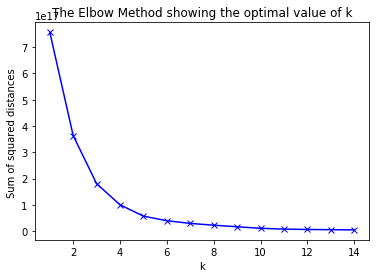

In [99]:
print("The elbow method to select the optimal number of clusters")
K = range(1,15)
distortions=[]
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
 
# Plot the elbowa
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances ')
plt.title('The Elbow Method showing the optimal value of k')
plt.show()

In [100]:
print("The minimum sum of sqaures of distances is :",min(distortions)," for k",distortions.index(min(distortions)))

The minimum sum of sqaures of distances is : 4.35216352008e+15  for k 13


### K-means on scaled data

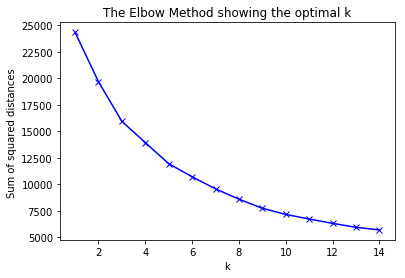

In [101]:
K = range(1,15)
distortions=[]
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0)
    kmeanModel.fit(scaled_X)
    distortions.append(kmeanModel.inertia_)
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances ')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [102]:
print("The minimum sum of sqaures of distances is :",min(distortions)," for k",distortions.index(min(distortions)))

The minimum sum of sqaures of distances is : 5714.45093834  for k 13


### K-Menas with scaled PCA data

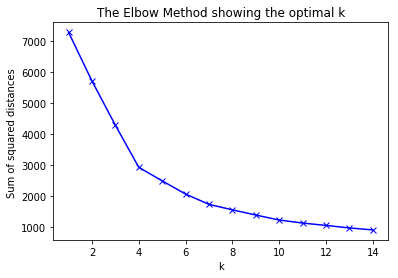

In [132]:
K = range(1,15)
distortions=[]
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0)
    kmeanModel.fit(X_pca_scaled)
    distortions.append(kmeanModel.inertia_)
 
# Plot the elbowa
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances ')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [133]:
print("The minimum sum of sqaures of distances is :",min(distortions)," for k",distortions.index(min(distortions)))

The minimum sum of sqaures of distances is : 911.604365747  for k 13


Plot by creating 13 clusters using K-Means on scaled PCA data


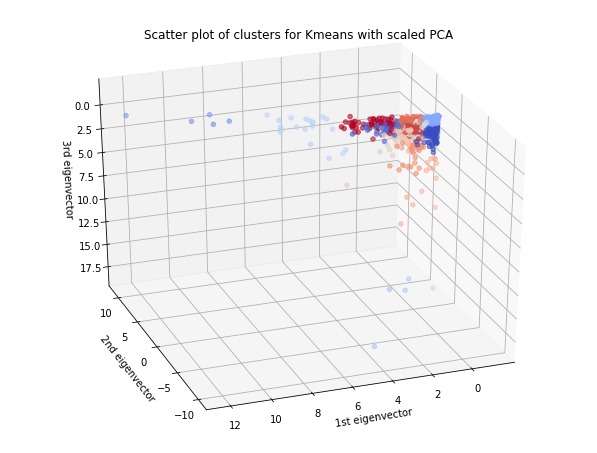

In [134]:
print("Plot by creating 13 clusters using K-Means on scaled PCA data")
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], X_pca_scaled[:, 2],c=kmeanModel.labels_,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for Kmeans with scaled PCA")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

In [135]:
kmeanModel = KMeans(n_clusters=2,random_state=0,verbose=False)
kmeanModel.fit(X_pca_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=False)

In [136]:
print("The sum of sqaures of distances using 2 clusters for scaled PCA data is:",kmeanModel.inertia_)

The sum of sqaures of distances using 2 clusters for scaled PCA data is: 5723.87447783


Plot by creating 2 clusters using K-Means on scaled PCA data


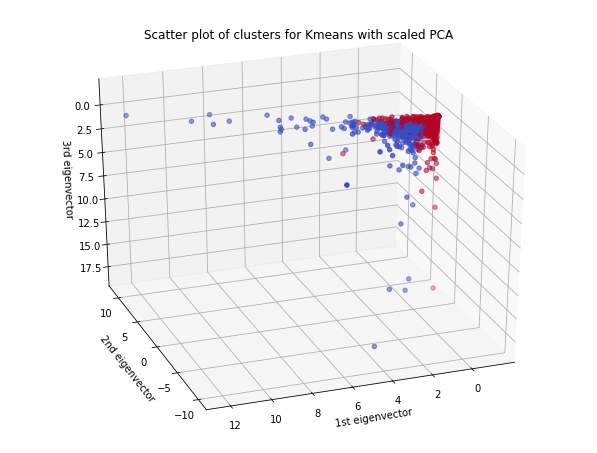

In [137]:
print("Plot by creating 2 clusters using K-Means on scaled PCA data")
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], X_pca_scaled[:, 2],c=kmeanModel.labels_,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for Kmeans with scaled PCA")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

Scatter plots by the original label: Infected vs Uninfected


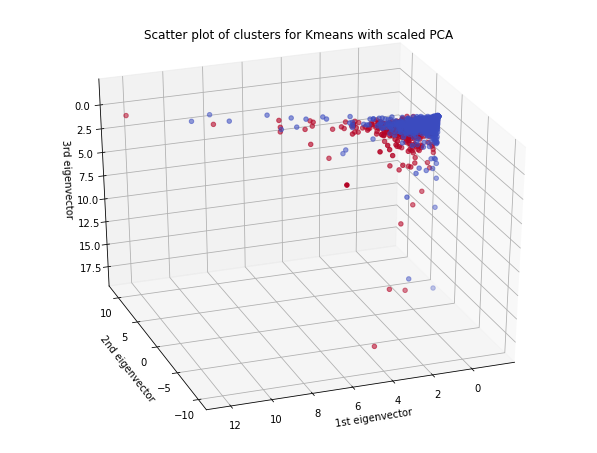

In [138]:
print("Scatter plots by the original label: Infected vs Uninfected")
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], X_pca_scaled[:, 2],c=z.Target,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for Kmeans with scaled PCA")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

### Kmeans with PCA

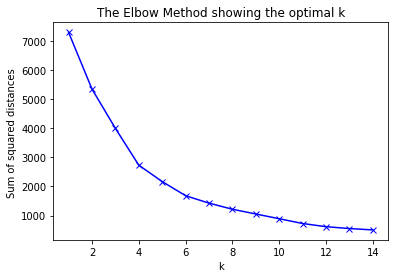

In [139]:
K = range(1,15)
distortions=[]
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0)
    kmeanModel.fit(X_pca)
    distortions.append(kmeanModel.inertia_)
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances ')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [140]:
print("The minimum sum of sqaures of distances is :",min(distortions)," for k",distortions.index(min(distortions)))

The minimum sum of sqaures of distances is : 507.92488334  for k 13


Plot by creating 13 clusters using K-Means on PCA data


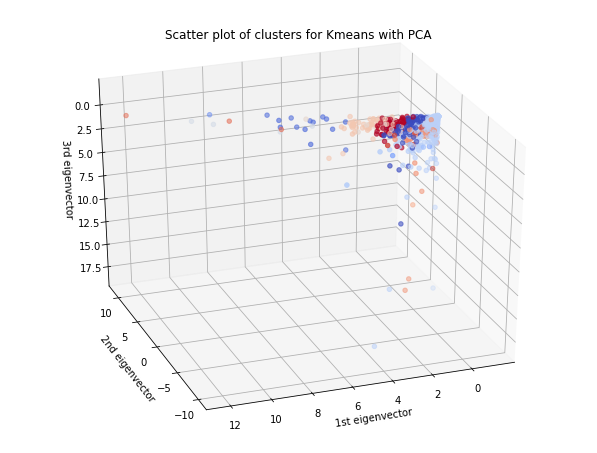

In [141]:
print("Plot by creating 13 clusters using K-Means on PCA data")
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], X_pca_scaled[:, 2],c=kmeanModel.labels_,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for Kmeans with PCA")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

In [142]:
kmeanModel = KMeans(n_clusters=2,random_state=0,verbose=False)
kmeanModel.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=False)

In [143]:
print("The sum of sqaures of distances using 2 clusters for PCA data is:",kmeanModel.inertia_)

The sum of sqaures of distances using 2 clusters for PCA data is: 5348.97104045


Plot by creating 2 clusters using K-Means on scaled PCA data


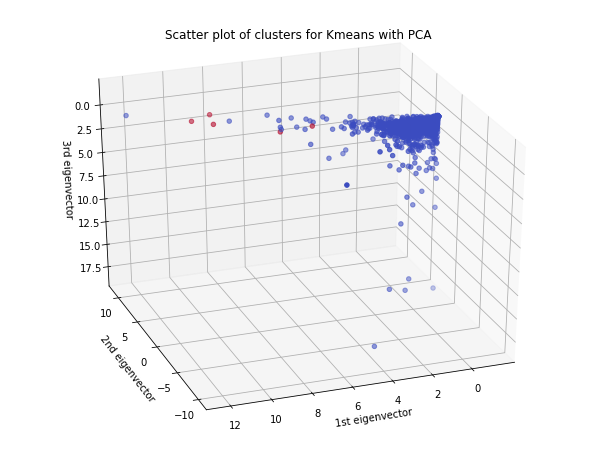

In [144]:
print("Plot by creating 2 clusters using K-Means on scaled PCA data")
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], X_pca_scaled[:, 2],c=kmeanModel.labels_,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for Kmeans with PCA")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

Scatter plots by the original label: Infected vs Uninfected


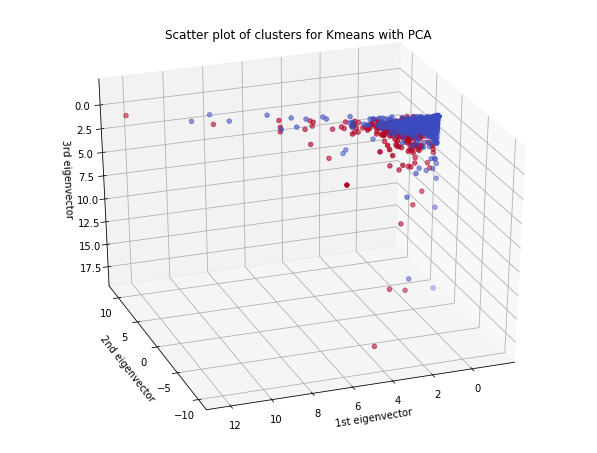

In [145]:
print("Scatter plots by the original label: Infected vs Uninfected")
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], X_pca_scaled[:, 2],c=z.Target,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for Kmeans with PCA")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

### DBSCAN

In [192]:
dbscan=DBSCAN(eps=0.5,min_samples=20,metric='euclidean',algorithm='auto',leaf_size=50)
dbscan.fit(X_pca)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=50, metric='euclidean',
    metric_params=None, min_samples=20, n_jobs=1, p=None)

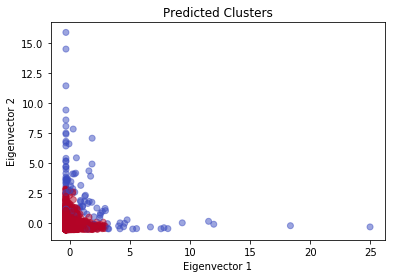

In [196]:
plt.scatter(X_pca[:,0],X_pca[:,1],c=dbscan.labels_,cmap=plt.cm.coolwarm,alpha=0.5)
plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')
plt.title('Predicted Clusters')
plt.show()

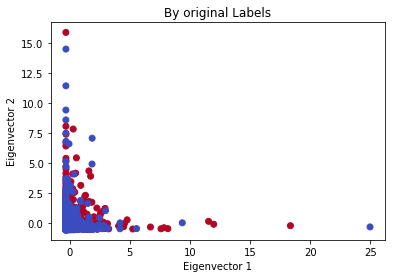

In [197]:
plt.scatter(X_pca[:,0],X_pca[:,1],c=z.Target,cmap=plt.cm.coolwarm)
plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')
plt.title('By original Labels')
plt.show()
plt.show()

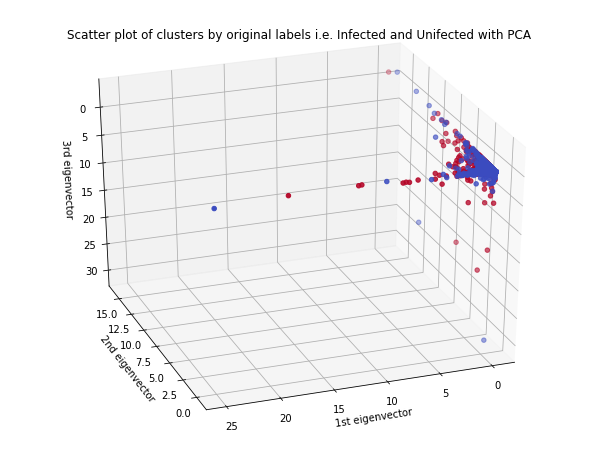

In [198]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],c=z.Target,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters by original labels i.e. Infected and Unifected with PCA")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

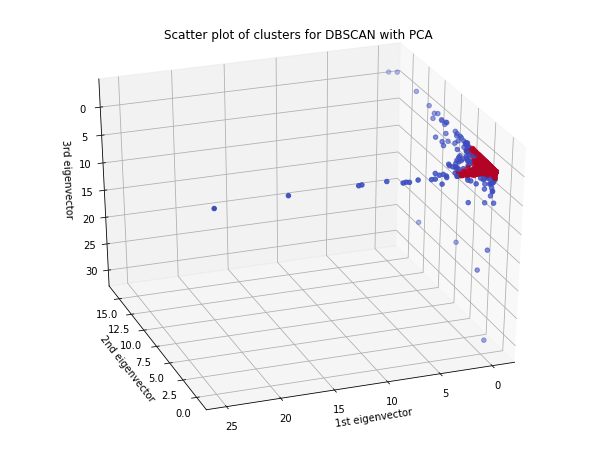

In [199]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],c=dbscan.labels_,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for DBSCAN with PCA")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

### K-Means with TSNE

In [200]:
from sklearn.manifold import TSNE
tsne=TSNE(n_components=3)
results=tsne.fit_transform(X)

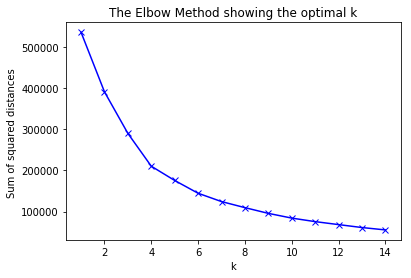

In [201]:
K = range(1,15)
distortions=[]
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0)
    kmeanModel.fit(results)
    distortions.append(kmeanModel.inertia_)
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances ')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [202]:
print("The minimum sum of sqaures of distances is :",min(distortions)," for k",distortions.index(min(distortions)))

The minimum sum of sqaures of distances is : 55393.5476913  for k 13


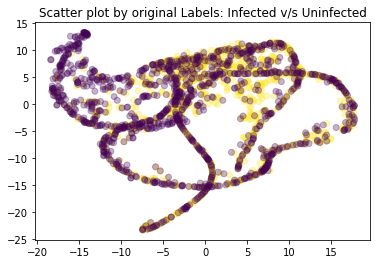

In [204]:
plt.scatter(results[:,0],results[:,1],c=z.Target,alpha=0.3)
plt.title("Scatter plot by original Labels: Infected v/s Uninfected")
plt.show()

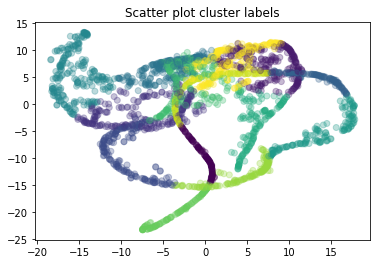

In [205]:
plt.scatter(results[:,0],results[:,1],c=kmeanModel.labels_,alpha=0.3)
plt.title("Scatter plot cluster labels")
plt.show()

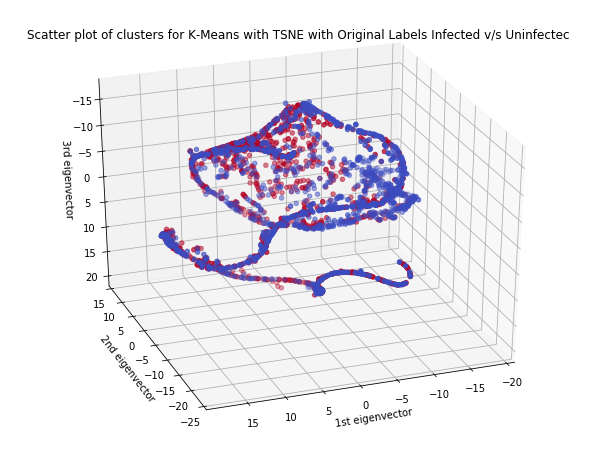

In [206]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(results[:, 0], results[:, 1], results[:, 2],c=z.Target,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for K-Means with TSNE with Original Labels Infected v/s Uninfected")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

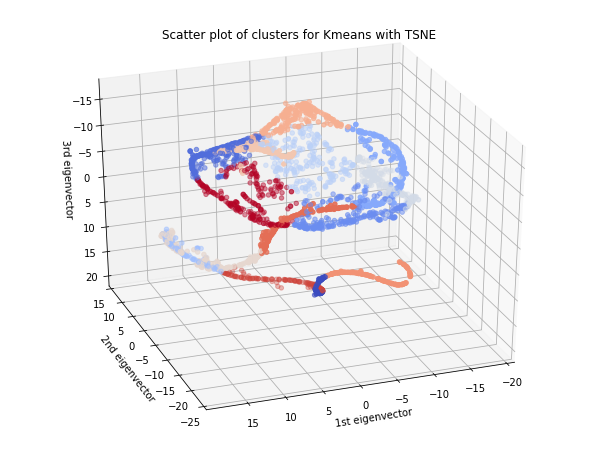

In [207]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(results[:, 0], results[:, 1], results[:, 2],c=kmeanModel.labels_,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for Kmeans with TSNE")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

### K-Means with TSNE on scaled dataa

In [208]:
tsne=TSNE(n_components=3)
results=tsne.fit_transform(scaled_X)

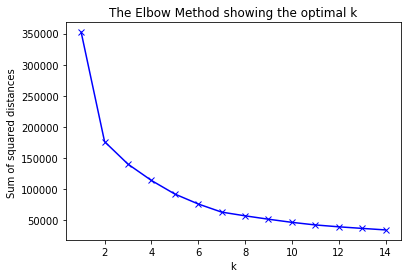

In [209]:
K = range(1,15)
distortions=[]
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0)
    kmeanModel.fit(results)
    distortions.append(kmeanModel.inertia_)
 
# Plot the elbowa
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances ')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [210]:
print("The minimum sum of sqaures of distances is :",min(distortions)," for k",distortions.index(min(distortions)))

The minimum sum of sqaures of distances is : 34487.0399313  for k 13


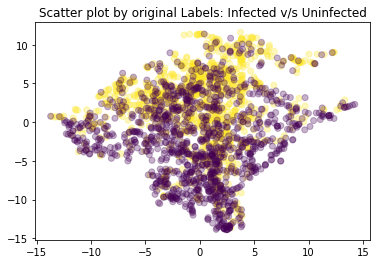

In [212]:
plt.scatter(results[:,0],results[:,1],c=z.Target,alpha=0.3)
plt.title("Scatter plot by original Labels: Infected v/s Uninfected")
plt.show()

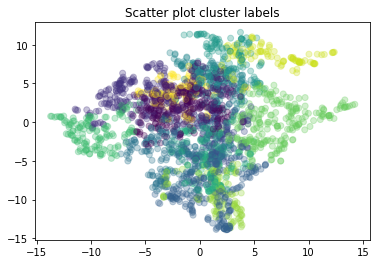

In [213]:
plt.scatter(results[:,0],results[:,1],c=kmeanModel.labels_,alpha=0.3)
plt.title("Scatter plot cluster labels")
plt.show()

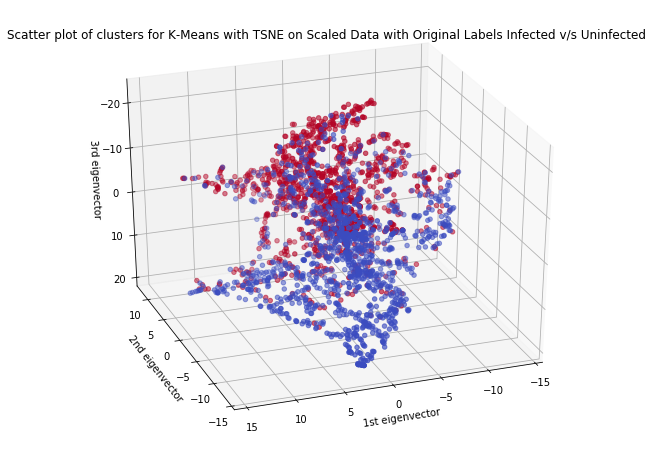

In [214]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(results[:, 0], results[:, 1], results[:, 2],c=z.Target,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for K-Means with TSNE on Scaled Data with Original Labels Infected v/s Uninfected")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

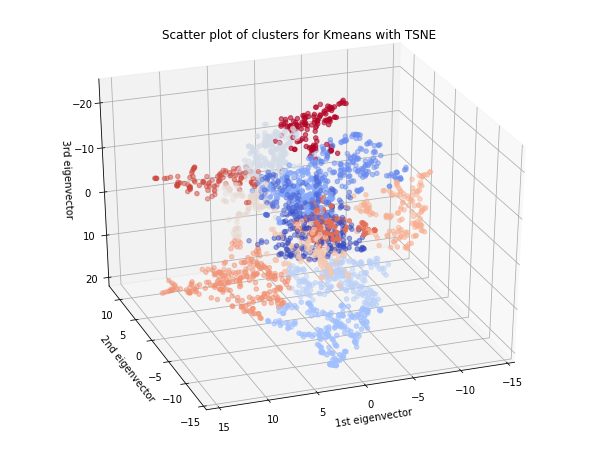

In [215]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(results[:, 0], results[:, 1], results[:, 2],c=kmeanModel.labels_,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for Kmeans with TSNE")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

### Agglomerative Clustering on PCA

In [231]:
agg=AgglomerativeClustering(n_clusters=3)
agg.fit(X_pca)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func=<function mean at 0x7fd8d4046048>)

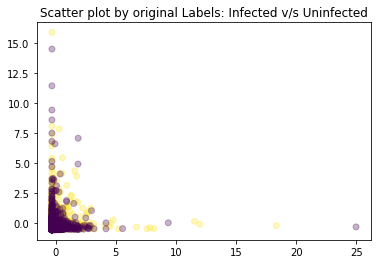

In [232]:
plt.scatter(X_pca[:,0],X_pca[:,1],c=z.Target,alpha=0.3)
plt.title("Scatter plot by original Labels: Infected v/s Uninfected")
plt.show()

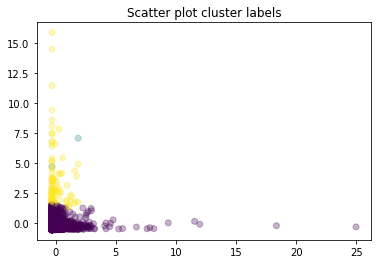

In [234]:
plt.scatter(X_pca[:,0],X_pca[:,1],c=agg.labels_,alpha=0.3)
plt.title("Scatter plot cluster labels")
plt.show()

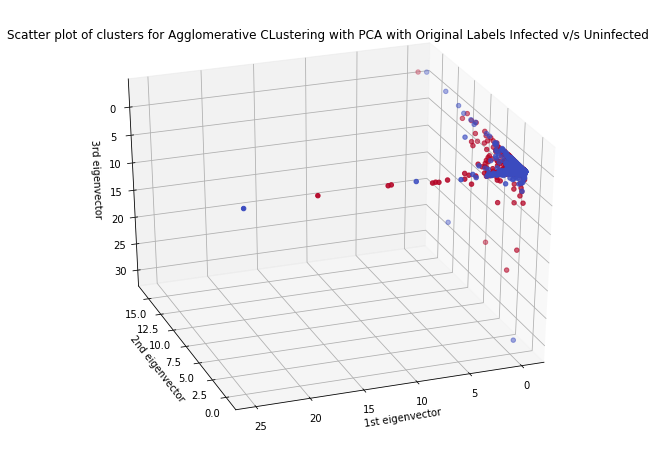

In [235]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(X_pca[:, 0], X_pca[:, 1],X_pca[:, 2],c=z.Target,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for Agglomerative CLustering with PCA with Original Labels Infected v/s Uninfected")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

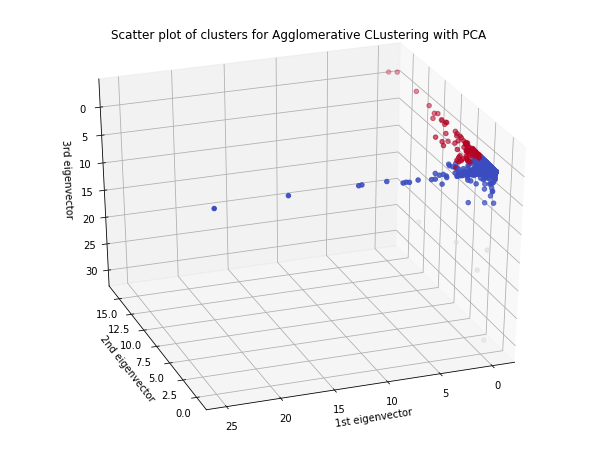

In [236]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(X_pca[:, 0], X_pca[:, 1],X_pca[:, 2],c=agg.labels_,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for Agglomerative CLustering with PCA")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

### Agglomerative Clustering using TSNE on scaled data

In [237]:
tsne=TSNE(n_components=3)
results=tsne.fit_transform(scaled_X)

In [239]:
agg=AgglomerativeClustering(n_clusters=3)
agg.fit(results)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func=<function mean at 0x7fd8d4046048>)

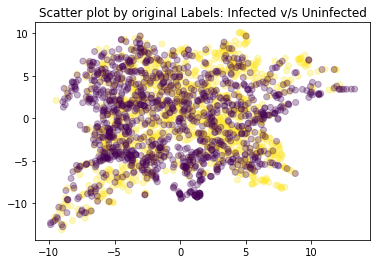

In [240]:
plt.scatter(results[:,0],results[:,1],c=z.Target,alpha=0.3)
plt.title("Scatter plot by original Labels: Infected v/s Uninfected")
plt.show()

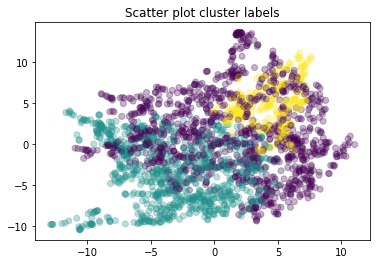

In [246]:
plt.scatter(results[:,0],results[:,1],c=agg.labels_,alpha=0.3)
plt.title("Scatter plot cluster labels")
plt.show()

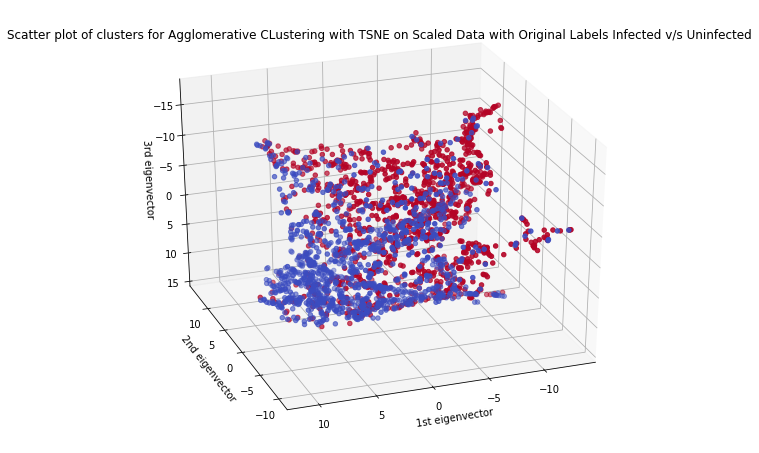

In [247]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(results[:, 0], results[:, 1], results[:, 2],c=z.Target,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for Agglomerative CLustering with TSNE on Scaled Data with Original Labels Infected v/s Uninfected")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

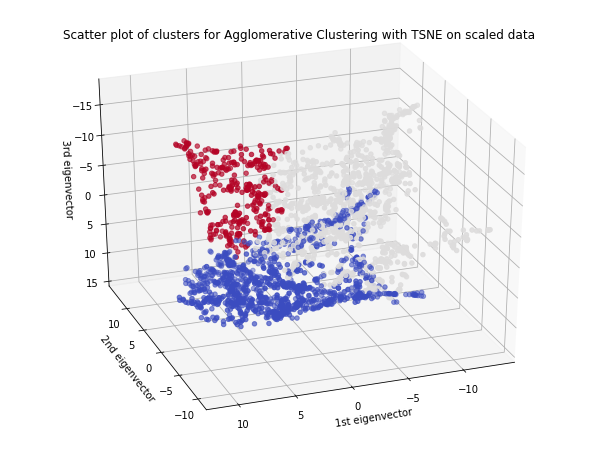

In [248]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(results[:, 0], results[:, 1], results[:, 2],c=agg.labels_,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for Agglomerative Clustering with TSNE on scaled data")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

### Spectral CLustering with TSNE on scaled data

In [245]:
tsne=TSNE(n_components=3)
results=tsne.fit_transform(scaled_X)

In [255]:
spec=SpectralClustering(3)
spec.fit(results)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=3, n_init=10, n_jobs=1, n_neighbors=10,
          random_state=None)

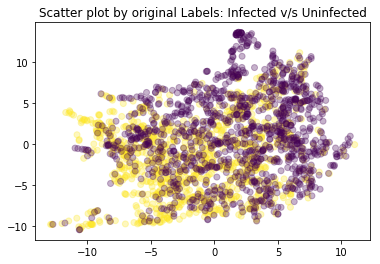

In [256]:
plt.scatter(results[:,0],results[:,1],c=z.Target,alpha=0.3)
plt.title("Scatter plot by original Labels: Infected v/s Uninfected")
plt.show()

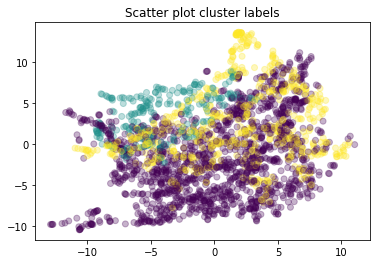

In [257]:
plt.scatter(results[:,0],results[:,1],c=spec.labels_,alpha=0.3)
plt.title("Scatter plot cluster labels")
plt.show()

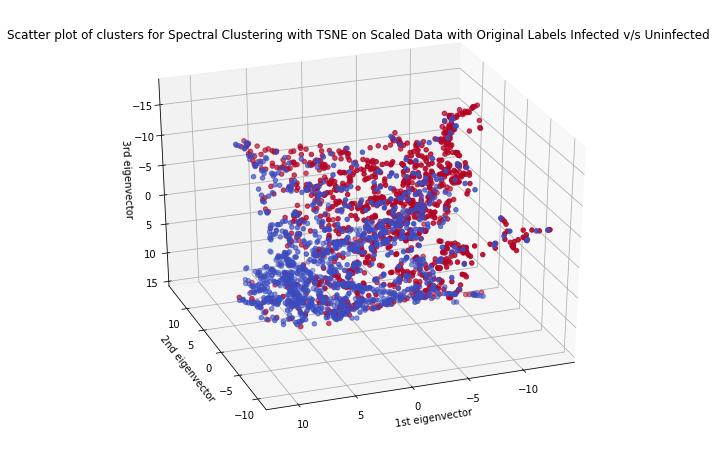

In [258]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(results[:, 0], results[:, 1], results[:, 2],c=z.Target,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for Spectral Clustering with TSNE on Scaled Data with Original Labels Infected v/s Uninfected")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

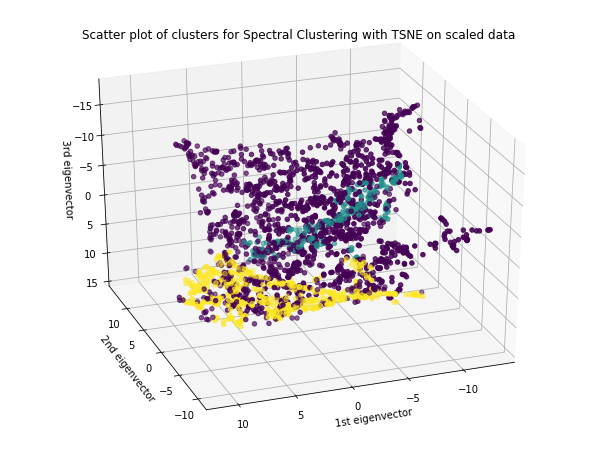

In [260]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(results[:, 0], results[:, 1], results[:, 2],c=spec.labels_,cmap=plt.cm.viridis)

ax.set_title("Scatter plot of clusters for Spectral Clustering with TSNE on scaled data")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

### Birch with TSNE on scaled data

In [273]:
birch=Birch(n_clusters=2)
birch.fit(results)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=2,
   threshold=0.5)

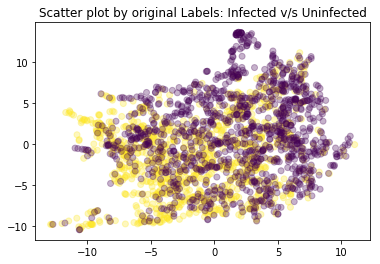

In [274]:
plt.scatter(results[:,0],results[:,1],c=z.Target,alpha=0.3)
plt.title("Scatter plot by original Labels: Infected v/s Uninfected")
plt.show()

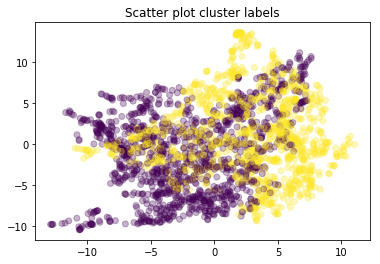

In [275]:
plt.scatter(results[:,0],results[:,1],c=birch.labels_,alpha=0.3)
plt.title("Scatter plot cluster labels")
plt.show()

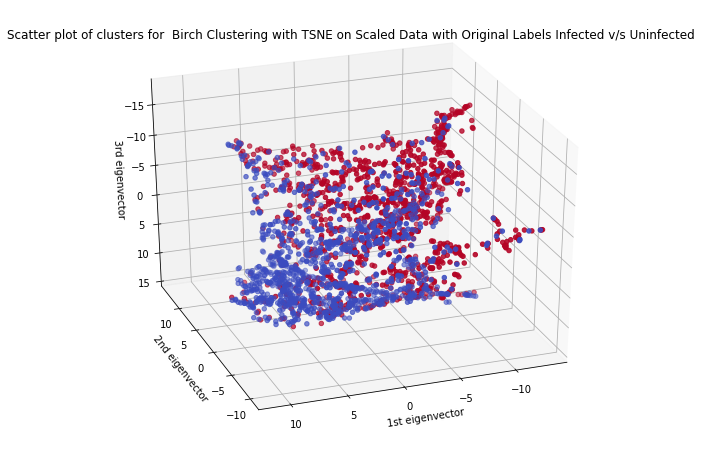

In [276]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(results[:, 0], results[:, 1], results[:, 2],c=z.Target,cmap=plt.cm.coolwarm)

ax.set_title("Scatter plot of clusters for  Birch Clustering with TSNE on Scaled Data with Original Labels Infected v/s Uninfected")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

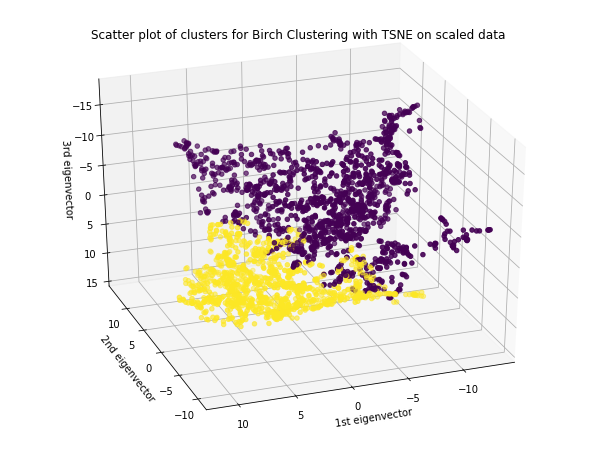

In [277]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)


ax.scatter(results[:, 0], results[:, 1], results[:, 2],c=birch.labels_,cmap=plt.cm.viridis)

ax.set_title("Scatter plot of clusters for Birch Clustering with TSNE on scaled data")
ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])


ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()

In [278]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')